In [5]:
# -------------------------------
# ✅ Step 1: Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import pickle
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------------
# ✅ Step 2: Load Dataset
# -------------------------------
data = pd.read_excel("Dataset.xlsx")  # Adjust path if needed
print("Data Shape:", data.shape)
data.head()

Data Shape: (1216, 25)


,Timestamp,Gender,Age,Your major,"Have you ever been diagnosed with a mental health condition by a professional (doctor, therapist, etc.)?",Have you ever received treatment/support for a mental health problem?,When have you usually gone to bed in the past month?,How long has it taken you to fall asleep each night in the past month?,What time have you usually gotten up in the morning in the past month?,How many hours of actual sleep did you get on an average for the past month? (maybe different from the number of hours spent in bed),...,"During the past month, how often have you had trouble sleeping because you: (choose an option that indicate the most accurate reply for the majority of days and nights in the past month) [Feel too hot]","During the past month, how often have you had trouble sleeping because you: (choose an option that indicate the most accurate reply for the majority of days and nights in the past month) [Have bad dreams]","During the past month, how often have you had trouble sleeping because you: (choose an option that indicate the most accurate reply for the majority of days and nights in the past month) [Have pain]",What is your stress level in these given situations [You have to submit an assignment in less than a day],What is your stress level in these given situations [A week before exams],What is your stress level in these given situations [Asking for an extra ketchup packet at a restaurant],What is your stress level in these given situations [Meeting a new person ],What is your stress level in these given situations [Asking for help],What is your stress level in these given situations [Confronting someone],What is your stress level in these given situations [Doing something without help]
0,2021-11-06 21:55:50.465000,Male,18-20,Mechanical,No,No,9pm-11pm,30 minutes,8 -10 am,7-8 hours,...,Less than once a week,Not during the past month,Not during the past month,moderate,mild,not stressed,not stressed,not stressed,moderate,not stressed
1,2021-11-06 22:00:18.873000,Non-binary,18-20,EEE/ECE,Yes,Yes,1am-3am,More time than 2 hours,after 10 am,7-8 hours,...,Once or twice a week,Three or more times a week,Three or more times a week,severe,moderate,severe,severe,severe,severe,moderate
2,2021-11-06 22:04:49.692000,Non-binary,18-20,Computer Science,Yes,Yes,11pm-1am,30 minutes,before 8 am,7-8 hours,...,Not during the past month,Once or twice a week,Once or twice a week,moderate,moderate,moderate,moderate,moderate,moderate,moderate
3,2021-11-06 22:05:30.780000,Female,18-20,Biotech,No,No,11pm-1am,1 hour,after 10 am,7-8 hours,...,Once or twice a week,Less than once a week,Not during the past month,severe,mild,not stressed,mild,mild,moderate,not stressed
4,2021-11-06 22:07:40.036000,Female,18-20,Computer Science,Yes,No,1am-3am,30 minutes,8 -10 am,more than 8 hours,...,Less than once a week,Less than once a week,Once or twice a week,very severe,very severe,moderate,severe,very severe,very severe,very severe


In [6]:
# -------------------------------
# ✅ Step 3: Clean Age Column
# -------------------------------
age_mapping = {
    '18-20': 19, '21-25': 23, '26-30': 28, '31-35': 33, '36-40': 38,
    '41-45': 43, '46-50': 48, '51-55': 53, '56-60': 58, '61-65': 63, '65+': 68
}
data['Age'] = data['Age'].map(age_mapping)


# -------------------------------
# ✅ Step 4: Map Frequency & Stress Levels
# -------------------------------
frequency_mapping = {
    'Not during the past month': 0,
    'Less than once a week': 1,
    'Once or twice a week': 2,
    'Three or more times a week': 3
}

stress_level_mapping = {
    'not stressed': 0,
    'mild': 1,
    'moderate': 2,
    'severe': 3,
    'very severe': 4
}

frequency_columns = [col for col in data.columns if "During the past month" in col]
stress_columns = [col for col in data.columns if "What is your stress level" in col]

for col in frequency_columns:
    data[col] = data[col].map(frequency_mapping)

for col in stress_columns:
    data[col] = data[col].map(stress_level_mapping)

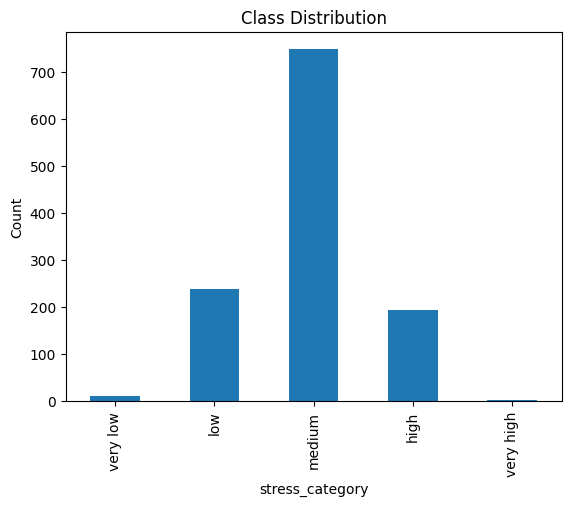

In [7]:
# -------------------------------
# ✅ Step 5: Create Target Column
# -------------------------------
data['average_stress'] = data[stress_columns].mean(axis=1)
data['stress_category'] = pd.cut(
    data['average_stress'],
    bins=[-1, 0.5, 1.5, 2.5, 3.5, 5],
    labels=["very low", "low", "medium", "high", "very high"]
)
data.dropna(inplace=True)


# -------------------------------
# ✅ Step 6: Visualize Class Distribution
# -------------------------------
label_counts = data['stress_category'].value_counts().sort_index()
label_counts.plot(kind='bar', title='Class Distribution', ylabel='Count')
plt.show()

In [8]:
# -------------------------------
# ✅ Step 7: Prepare Features
# -------------------------------
categorical_features = [
    'Gender', 'Your major',
    'Have you ever been diagnosed with a mental health condition by a professional (doctor, therapist, etc.)?',
    'Have you ever received treatment/support for a mental health problem?',
    'When have you usually gone to bed in the past month?',
    'How long has it taken you to fall asleep each night in the past month?',
    'What time have you usually gotten up in the morning in the past month?',
    'How many hours of actual sleep did you get on an average for the past month? (maybe different from the number of hours spent in bed)'
]

numeric_features = ['Age'] + frequency_columns
target = "stress_category"

X = data[categorical_features + numeric_features]
y = data[target]

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


# -------------------------------
# ✅ Step 8: Preprocessing & SMOTE (Fixed)
# -------------------------------
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", StandardScaler(), numeric_features)
])

X_processed = preprocessor.fit_transform(X)

# Balance dataset using SMOTE with safe k_neighbors
smote = SMOTE(random_state=42, k_neighbors=1)  # Changed from default 5 → 1
X_resampled, y_resampled = smote.fit_resample(X_processed, y_encoded)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)


In [9]:
# -------------------------------
# ✅ Step 9: Model Training with GridSearchCV
# -------------------------------
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [10]:
# -------------------------------
# ✅ Step 10: Evaluation
# -------------------------------
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n✅ Accuracy:", acc)
print("✅ Precision:", prec)
print("✅ Recall:", rec)
print("✅ F1 Score:", f1)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))


✅ Accuracy: 0.890520694259012
✅ Precision: 0.9159837902931286
✅ Recall: 0.890520694259012
✅ F1 Score: 0.892544819645798

📊 Classification Report:
               precision    recall  f1-score   support

        high       0.98      0.74      0.84       150
         low       0.94      0.75      0.84       149
      medium       0.67      0.96      0.79       150
   very high       1.00      1.00      1.00       150
    very low       0.99      1.00      0.99       150

    accuracy                           0.89       749
   macro avg       0.92      0.89      0.89       749
weighted avg       0.92      0.89      0.89       749



In [11]:
# -------------------------------
# ✅ Step 11: MLflow Logging
# -------------------------------
mlflow.set_experiment("Enhanced_Stress_Prediction")

with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    input_example = pd.DataFrame(X.iloc[:2])
    signature = infer_signature(X_train, y_train)

    mlflow.sklearn.log_model(best_model, "model", signature=signature, input_example=input_example)


# -------------------------------
# ✅ Step 12: Save Model to Disk
# -------------------------------
with open("model.pkl", "wb") as f:
    pickle.dump({
        "model": best_model,
        "preprocessor": preprocessor,
        "label_encoder": le_target,
        "features": categorical_features + numeric_features
    }, f)

print("\n🎉 Model and pipeline saved as model.pkl")

2025/05/31 22:35:58 INFO mlflow.tracking.fluent: Experiment with name 'Enhanced_Stress_Prediction' does not exist. Creating a new experiment.


2025/05/31 22:36:04 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "Gender",
      "Your major",
      "Have you ever been diagnosed with a mental health condition by a professional (doctor, therapist, etc.)?",
      "Have you ever received treatment/support for a mental health problem?",
      "When have you usually gone to bed in the past month?",
      "How long has it taken you to fall asleep each night in the past month?",
      "What time have you usually gotten up in the morning in the past month?",
      "How many hours of actual sleep did you get on an average for the past month? (maybe different from the number of hours spent in bed)",
      "Age",
      " During the past month, how often have you had trouble sleeping because you: (choose an option that indicate the most accurate reply for the majority of days and nights in the past month) [Cannot get to sleep within 30 minutes]",
      " During the past m


🎉 Model and pipeline saved as model.pkl
